# Module 8 Homework - Deep Learning
Homework link: https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/08-deep-learning/homework.md

[Open in Colab](https://colab.research.google.com/drive/18RpkGF7pHQC0KImuHCyIAkTLZ26vM9rs?usp=sharing)

## 1. Question 1
nn.BCEWithLogitsLoss()

Imports

In [1]:
import os
import numpy as np

from PIL import Image
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets

from torchsummary import summary


## Get Data

In [2]:
!wget 'https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip'
!unzip data.zip

--2025-12-01 22:06:48--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-01T22%3A43%3A51Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-01T21%3A43%3A28Z&ske=2025-12-01T22%3A43%3A51Z&sks=b&skv=2018-11-09&sig=0qIVfMi5gK1Cu9S42GgPQBtqiPz13h%2Bs8bLcfCBFp6U%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDYyODU2MiwibmJmIjoxNzY0NjI2NzYyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

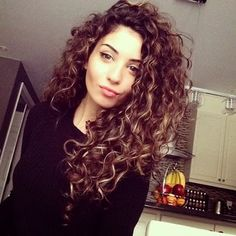

In [3]:
img = Image.open('data/train/curly/images711.jpg')
img

Setting seed generators

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preparation
Defining images transformations as input must be (3, 200, 200).

In [5]:
input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [6]:
class HairStylingData(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
batch_size=20
shuffle_training = True
shuffle_test = False

In [8]:
train_dataset = HairStylingData(
    data_dir='/content/data/train',
    transform=train_transforms
)

validation_dataset = HairStylingData(
    data_dir='/content/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_training)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=shuffle_test)

In [9]:
print(f"Found Classes: {train_dataset.classes}")
print(f"Size train Dataset: {len(train_dataset)}")
print(f"Size validation Dataset: {len(validation_dataset)}")

Found Classes: ['curly', 'straight']
Size train Dataset: 801
Size validation Dataset: 201


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class HairTypeClassifier(nn.Module):
    def __init__(self):
        super(HairTypeClassifier, self).__init__()

        # Next, create a convolutional layer (nn.Conv2d)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,  # Use 32 filters (output channels)
            kernel_size=(3, 3), # Kernel size should be (3, 3)
            # padding = 0, stride = 1
            stride=1,
            padding=0
        )
        # Use 'relu' as activation
        self.relu1 = nn.ReLU()

        # Reduce the size of the feature map with max pooling (nn.MaxPool2d)
        # Set the pooling size to (2, 2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # using flatten
        self.flattened_size = 32 * 99 * 99

        # add a nn.Linear layer with 64 neurons and 'relu' activation
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.relu2 = nn.ReLU()

        # Finally, create the nn.Linear layer with 1 neuron
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)

        # Reducir a vector (Flatten)
        x = x.view(-1, self.flattened_size)

        x = self.relu2(self.fc1(x))
        x = self.fc2(x)

        return x

# Instance
model = HairTypeClassifier().to(device)

In [12]:
# Loss Function choosen in the Question 1
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

## Question 2

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 20073473


# Generators and Training


In [14]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6500, Acc: 0.5980, Val Loss: 0.5966, Val Acc: 0.6617
Epoch 2/10, Loss: 0.5670, Acc: 0.6954, Val Loss: 0.6158, Val Acc: 0.6667
Epoch 3/10, Loss: 0.5171, Acc: 0.7253, Val Loss: 0.5932, Val Acc: 0.6766
Epoch 4/10, Loss: 0.4743, Acc: 0.7640, Val Loss: 0.6195, Val Acc: 0.6517
Epoch 5/10, Loss: 0.4134, Acc: 0.8040, Val Loss: 0.7173, Val Acc: 0.6368
Epoch 6/10, Loss: 0.4359, Acc: 0.7940, Val Loss: 0.6727, Val Acc: 0.6368
Epoch 7/10, Loss: 0.3327, Acc: 0.8527, Val Loss: 0.7522, Val Acc: 0.6418
Epoch 8/10, Loss: 0.2913, Acc: 0.8652, Val Loss: 1.1109, Val Acc: 0.5721
Epoch 9/10, Loss: 0.2779, Acc: 0.8801, Val Loss: 0.6870, Val Acc: 0.7463
Epoch 10/10, Loss: 0.4130, Acc: 0.8115, Val Loss: 0.6621, Val Acc: 0.7512


## Question 3

In [15]:
accuracy = pd.Series(history['acc'])
accuracy.median()

0.7990012484394506

## Question 4

In [16]:
train_loss = pd.Series(history['loss'])
train_loss.std()

0.11956483420625565

# Data Augmentation

In [17]:
# Training Aumentations
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [18]:
train_dataset = HairStylingData(
    data_dir='/content/data/train',
    transform=train_transforms
)

validation_dataset = HairStylingData(
    data_dir='/content/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_training)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=shuffle_test)

In [19]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6254, Acc: 0.6667, Val Loss: 0.5893, Val Acc: 0.7015
Epoch 2/10, Loss: 0.5665, Acc: 0.6804, Val Loss: 0.5604, Val Acc: 0.6816
Epoch 3/10, Loss: 0.5419, Acc: 0.7241, Val Loss: 0.6665, Val Acc: 0.6119
Epoch 4/10, Loss: 0.5371, Acc: 0.7303, Val Loss: 0.6454, Val Acc: 0.6716
Epoch 5/10, Loss: 0.5142, Acc: 0.7478, Val Loss: 0.6579, Val Acc: 0.6716
Epoch 6/10, Loss: 0.5249, Acc: 0.7091, Val Loss: 0.6114, Val Acc: 0.6816
Epoch 7/10, Loss: 0.5236, Acc: 0.7166, Val Loss: 0.5811, Val Acc: 0.7214
Epoch 8/10, Loss: 0.5069, Acc: 0.7403, Val Loss: 0.6023, Val Acc: 0.6667
Epoch 9/10, Loss: 0.5489, Acc: 0.7129, Val Loss: 0.5578, Val Acc: 0.7065
Epoch 10/10, Loss: 0.4981, Acc: 0.7491, Val Loss: 0.5438, Val Acc: 0.6965


## Question 5

In [20]:
val_loss = pd.Series(history['val_loss'])
val_loss.mean()

np.float64(0.6015856873957599)

## Question 6

In [21]:
val_accuracy = pd.Series(history['val_acc'][5:])
val_accuracy.mean()

np.float64(0.6945273631840796)